# E. coli Promoter Classification with Genomic Pretraining

This notebook builds on the previous one. Here, we show how using the [ULMFiT](https://arxiv.org/abs/1801.06146) technique of pretraining the classification model as a language model significantly improves performance. 

The "language model" here is a genomic prediction model. Given a sequence of input genomic tokens, the model outputs predictions of what token will be next. As described in the previous notebook, the genomic sequence will be represented by 5bp tokens with a stride of 2 between tokens.

This allows us to train a model that learns representations of genomic tokens in a totally unsupervised way. The key difference that makes this technique different from previous methods that leverage pretraining for genomic classification (see [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6020378/), [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5954283/) and [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6189047/)) is we use a large, unlabeled genomic corpus. Previous implementations of unsupervised pre-training train on only the classification corpus or a synthetically generated corpus of sequences similar to the classification corpus. These methods limit the pre-training corpus by the user's ability to gather labeled data.

Comparatively, the UMLFiT approach allows us to use any large corpus of genomic data, regardless of its relation to the classification data. This allows us to pretrain on more data and generate better models.

Once the genomic language model is trained, we can transfer the encoding section of the model (embedding + LSTM layers) to the classification model. This allows us to port over more pretrained weights than just the vector embeddings for the k-mers.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from typing import Callable

# sets device for model and PyTorch tensors
os.environ["CUDA_VISIBLE_DEVICES"]="0"
#os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3,4,5,6,7" # "-1" if want to run on a CPU, otherwise define the GPU number

In [3]:
from fastai import *
from fastai.text import ( BaseTokenizer, Tokenizer, Vocab, 
                         PreProcessor, ItemList, PathOrStr, 
                         DataFrame, Optional, Collection, 
                         IntsOrStrs, DataBunch, is_listy, 
                         ItemLists, TextList, SortishSampler, 
                         DataLoader, SortSampler, partial, 
                         pad_collate, TextLMDataBunch, data_collate, 
                         LanguageModelPreLoader )
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
import networkx as nx

In [4]:
sys.path.append("../..")
from utils import ( _get_genomic_processor, get_model_clas, TextClasDataBunch, 
                    get_scores, split_data, GenomicTokenizer, get_model_LM, 
                   GenomicVocab, GenomicTextClasDataBunch)

In [5]:
path = Path('/mnt/wd_4tb/shared_disk_wd4tb/mattscicluna/data/genomic_ulmfit/ecoli/')

In [6]:
df = pd.read_csv(path/'e_coli_lm_data.csv')

The language model data is just long strings of genomic information

In [7]:
df.head()

,Sequence,is_train
0,AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATT...,1
1,GGTTTCACCGCCGGTAATGAAAAAGGCGAACTGGTGGTGCTTGGAC...,1
2,AGCTGGCTGAAGAATAAACATATCGACTTACGTGTCTGCGGTGTTG...,1
3,CCGTTGGTACTGCGCGGATATGGTGCGGGCAATGACGTTACAGCTG...,1
4,CGCTCTGTGTGACAAGCCGGAAACCGCCCAGCGCGTTGCCGACTGG...,1


In [8]:
# 10% of the data used for validation
train_df, valid_df = split_data(df, 0.9)

# Tokenization and Numericalization

The tokenization functions are the same as those described in the previous notebook

In [9]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])

# Data Processing

To create our dataloader, we use a slightly different variant of the classification dataloader. The `GenomicTextLMDataBunch` class sets up the data with a language model structure, where the correct y value for each token is the next sequential token.

In [10]:
class GenomicTextLMDataBunch(TextLMDataBunch):
    @classmethod
    def from_df(cls, path:PathOrStr, train_df:DataFrame, valid_df:DataFrame, test_df:Optional[DataFrame]=None,
                tokenizer:Tokenizer=None, vocab:Vocab=None, classes:Collection[str]=None, text_cols:IntsOrStrs=1,
                label_cols:IntsOrStrs=0, label_delim:str=None, chunksize:int=10000, max_vocab:int=60000,
                min_freq:int=2, mark_fields:bool=False, bptt=70, collate_fn:Callable=data_collate, bs=64, **kwargs):
        "Create a `TextDataBunch` from DataFrames. `kwargs` are passed to the dataloader creation."
        processor = _get_genomic_processor(tokenizer=tokenizer, vocab=vocab, chunksize=chunksize, max_vocab=max_vocab,
                                   min_freq=min_freq, mark_fields=mark_fields)
        if classes is None and is_listy(label_cols) and len(label_cols) > 1: classes = label_cols
        src = ItemLists(path, TextList.from_df(train_df, path, cols=text_cols, processor=processor),
                        TextList.from_df(valid_df, path, cols=text_cols, processor=processor))
        src = src.label_for_lm() 
        if test_df is not None: src.add_test(TextList.from_df(test_df, path, cols=text_cols))
        d1 = src.databunch(**kwargs)
        
        datasets = cls._init_ds(d1.train_ds, d1.valid_ds, d1.test_ds)            
        val_bs = bs
        datasets = [LanguageModelPreLoader(ds, shuffle=(i==0), bs=(bs if i==0 else val_bs), bptt=bptt, backwards=False) 
                    for i,ds in enumerate(datasets)]            
        dls = [DataLoader(d, b, shuffle=False) for d,b in zip(datasets, (bs,val_bs,val_bs,val_bs)) if d is not None]
        
        return cls(*dls, path=path, collate_fn=collate_fn, no_check=False)

In [11]:
data = GenomicTextLMDataBunch.from_df(path, train_df, valid_df, bs=428, tokenizer=tok, text_cols=0, label_cols=1)

In [12]:
# Model vocabulary - 1025 tokens. 1024 5-mer nucleotide combinations plus one padding token
len(data.vocab.itos)

1025

In [13]:
data.train_ds[0]

(Text [680 198  57 337 ... 492  42  25 128], EmptyLabel 0)

Here we save the `itos` list from the dataloader as a numpy array. This is extremely important. When we transfer the pretrained weights from the language model to the classification model, we need to ensure the mapping from k-mers to integer ids is the same. Otherwise the embedding will be completely scrambled.

In [14]:
np.save(path/'coli_vocab.npy', data.vocab.itos)

# Language Model

The configuration of the language model is very similar to the classification model. This is because we need the sizes of the embedding and LSTM layers in the language model to match those we want in the classification model.

In [15]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult = 0.3

In [16]:
learn = get_model_LM(data, drop_mult, config)

In [17]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(1025, 400, padding_idx=0)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(1025, 400, padding_idx=0)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=1025, bias=True)
    (output_dp): RNNDropout()
  )
)

The model is trained using the same learning rate/momentum scheduling described in the previous notebook.

#### A note on language model performance

If you decide to play around with different genomes, different k-mer sizes or strides, there are some important things to know about comparing performance between models. We measure performance via cross entropy loss and accuracy. These values are strongly influenced by the stride of the k-mers.

Consider our stride 2 case. Any k-mer XXABC will be followed by a k-mer of the form ABCXX. The model quickly learns this mapping and places equal probability over all k-mers of the ABCXX form. For a stride of 2 (XX), this comes out to 16 (4^2) possible k-mers. I consider this point the baseline "random guessing" model that has only learned the most basic, obvious mapping encoded in the data. I think performance of these models should be measured relative to this baseline.

We can relate the number of possible "informed random guesses" to the expected perplexity/cross entropy of the model. If we assume that each k-mer is equally distributed in the dataset and each of the 16 possible ABCXX k-mers is given equal proability by the model, we would expect the model's perplexity to be 16 and the cross entropy to be ln(16)=2.77.

If you look at the validation loss of the model printed below, you can see it quickly trains down to a loss of around 2.7, then struggles to get lower. The model trains to a final validation loss of 2.63. This is to say the language model below is only slightly better than "informed random". However as we will see, this is more than enough to see a significant improvement in classification performance.

Understanding the relationship between stride and the "informed random" baseline is important for comparing models that use different stride values. If a model has a stride of 1, we expect an "informed random" mapping of XABCD --> ABCDX. This would give an expected perplexity of 4 and a cross entropy of ln(4) = 1.38. This means that a stride 1 model with a loss of 1.38 is performing comprably to a stride 2 model with a loss of 2.77.

Similarly for stride 3 models, we expect an "informed random" perplexity of 64 and a cross entropy of 4.15. Don't be fooled by the stride effect on apparent language model performance!

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


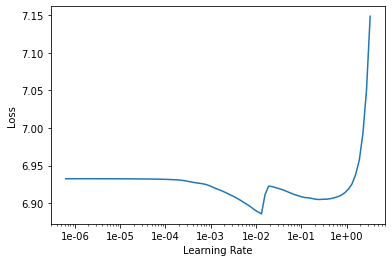

In [18]:
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(10, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,6.390528,5.628351,0.017014,02:07
1,5.003398,3.582359,0.081901,02:07
2,3.390509,2.764484,0.111570,02:07
3,2.923301,2.737711,0.113877,02:07
4,3.249879,3.180157,0.095440,02:07
5,2.886407,2.722292,0.118725,02:07
6,2.775461,2.714348,0.120181,02:07
7,2.742591,2.707726,0.122155,02:07
8,2.730118,2.704584,0.123440,02:07
9,2.725493,2.703644,0.124036,02:07


In [20]:
learn.fit_one_cycle(10, 5e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.723744,2.703796,0.123903,02:07
1,2.722206,2.687491,0.128922,02:07
2,2.705000,2.677531,0.132990,02:07
3,2.725945,2.671438,0.133724,02:07
4,2.693513,2.664365,0.134846,02:07
5,2.679919,2.655945,0.138547,02:07
6,2.662821,2.643842,0.143337,02:07
7,2.648116,2.637245,0.145310,02:07
8,2.637959,2.633863,0.146003,02:07
9,2.631199,2.633182,0.146099,02:07


In [21]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.626330,2.633605,0.146554,02:07
1,2.629747,2.632874,0.146262,02:07
2,2.627888,2.631174,0.146837,02:07
3,2.624083,2.629829,0.146712,02:07
4,2.619370,2.630835,0.146228,02:07
5,2.610542,2.627568,0.146946,02:07
6,2.604511,2.627935,0.147342,02:07
7,2.598504,2.627996,0.147225,02:07
8,2.593726,2.628239,0.147134,02:07
9,2.591153,2.628210,0.147367,02:07


Now we save the model and transfer over to classification.

#### A note on fine tuning

If we were to follow ULMFiT proper, the next step would be to fine tune the language model on the promoter corpus. In practice I have found that trying to fine tune the language model in this way quickly overfits, leading to worse classification performance. I believe this is due to the total text length of the promoter corpus. I will revisit this later with a larger dataset.

In [23]:
learn.save('coli_only_LM')

In [24]:
learn.save_encoder('coli_only_LM_enc')

# Classification

Now we run the classification procedure exactly the same as the last notebook. The only difference is now we initialize the classification model with the encoder (embedding + LSTMs) of the language model.

In [25]:
classification_df = pd.read_csv(path/'e_coli_promoters_dataset.csv')

In [26]:
classification_df.head()

,Gene,Locus,Location,Sample Location,Orientation,Sequence,Promoter,Independent,set
0,['yaaX'],['b0005'],[5233:5530](+),[5133:5283](+),forward,GTAACTTAGAGATTAGGATTGCGGAGAATAACAACCGCCGTTCTCA...,1,False,train
1,['talB'],['b0008'],[8237:9191](+),[8137:8287](+),forward,ATAACCGTCTTGTCGGCGGTTGCGCTGACGTTGCGTCGTGATATCA...,1,False,train
2,['yaaW'],['b0011'],[10642:11356](-),[11306:11456](-),reverse,TCAAAAATCACCTTTTCGGGTCATACGGTGAACTCATCGGATATGG...,1,False,train
3,['hokC'],['b4412'],[16750:16903](-),[16853:17003](-),reverse,AAAGCCCCGAGTGATATTTTACCATCAACCCGAGGCCTCCTATATG...,1,False,train
4,['nhaA'],['b0019'],[17488:18655](+),[17388:17538](+),forward,TAAAAAACGAATTATTCCTACACTATAATCTGATTTTAACGATGAT...,1,False,train


In [27]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

# Loading Vocabulary

Here we create a dataloader for tokenizing and numericalizing genomic sequences, same as before. However, we now pass in the vocabulary of the language model as a parameter for the classification dataloader. This ensures the mapping from k-mer to integer to embedding stays the same.

## If you do not do this, everything will fail

The exact order of the numericalization is based on the order in which tokens are processed. Different datasets or different shuffles of the same dataset __will__ have different vocabulary orders. If you try to transfer over a model with an incorrect vocabulary, it will basically refuse to train.

In [28]:
voc = np.load(path/'coli_vocab.npy')
model_vocab = GenomicVocab(voc)

In [29]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, valid_df, tokenizer=tok, vocab=model_vocab,
                                             text_cols='Sequence', label_cols='Promoter', bs=400)

Now we create the same classification model as before

In [30]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4, 
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.6

In [31]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [32]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(1025, 400, padding_idx=0)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(1025, 400, padding_idx=0)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.24, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): BatchNorm1d(50, e

We load the encoder of the language model

In [33]:
learn.load_encoder('coli_only_LM_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


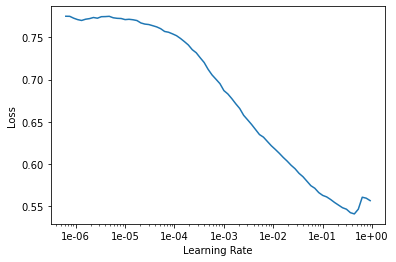

In [34]:
learn.lr_find()
learn.recorder.plot()

# Training procedure

Here we follow the ULMFiT procedure of training with gradual unfreezing. We first train only the new classification layer of the model, then gradually the lower LSTM and embedding layers.

You can see here that after a single epoch of training only the linear section (keeping the embedding/LSTMs as is from the language model) the classification model has achieved the same accuracy as the final model without pretraining.

When the entire model is being trained, we use discriminitive learning rates to train the lower layers of the model at a lower learning rate than the higher layers. This allows us to apply larger parameter updates to the new linear classification head, and smaller updates to the well-trained embedding.

In [35]:
learn.fit_one_cycle(3, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.483476,0.592509,0.658667,00:11
1,0.443874,0.498346,0.788000,00:11
2,0.421580,0.448669,0.800000,00:11


In [36]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.372104,0.420226,0.808000,00:13
1,0.355672,0.355075,0.850667,00:13
2,0.319257,0.323430,0.878667,00:13


In [37]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.264573,0.301154,0.894667,00:22
1,0.264839,0.308675,0.884000,00:22
2,0.251733,0.295629,0.888000,00:22


In [38]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.238078,0.294221,0.885333,00:28
1,0.235442,0.293664,0.889333,00:29
2,0.231839,0.297265,0.886667,00:29
3,0.227226,0.300446,0.889333,00:29
4,0.221232,0.302766,0.889333,00:29


In [39]:
learn.fit_one_cycle(5, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.213839,0.303212,0.885333,00:29
1,0.213545,0.303273,0.886667,00:29
2,0.212826,0.298954,0.889333,00:29
3,0.211931,0.299329,0.890667,00:29
4,0.211310,0.298591,0.889333,00:29


In [40]:
learn.save('coli_coli_pretrain', return_path=True)

PosixPath('/mnt/wd_4tb/shared_disk_wd4tb/mattscicluna/data/genomic_ulmfit/ecoli/models/coli_coli_pretrain.pth')

# Test

In [41]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, test_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Promoter', bs=300)
learn.data = data_clas

In [42]:
get_scores(learn)

Accuracy: 0.880722891566265
False Positives: 0.04578313253012048
False Negatives: 0.07349397590361446
Recall: 0.8530120481927711
Precision: 0.9030612244897959
Specificity: 0.908433734939759
MCC: 0.7626178984794199


Compared to the naive model, accuracy has increased from 83.4% to 91.9%, precision has increased from 0.84 to 0.94, recall has increased from 0.81 to 0.89, and the correlation coefficient has increased from 0.67 to 0.83.

The model is also much more stable during training and gives more reproducible results. Unsupervised pretraining helps a lot.

In fact, the best way to improve the model from this point is not to train more on the promoter dataset, but to create a better genomic language model from more genomic data. This is detailed in the next notebook.